Using device: cuda
Files already downloaded and verified
Files already downloaded and verified

Config:
CIFARConfig(alpha=0.1, K0=6, num_classes=10, num_simulations=10, epochs_per_view=40, lr=0.001, batch_size=512, max_iter_lr=1000, train_seed_base=42, train_frac=0.5, cal_frac_of_temp=0.3, fuse_train_frac_of_rest=0.7, viewdrop_min_missing=0, viewdrop_max_missing=5, viewdrop_prob=0.7, eval_min_missing=0, max_missing_to_eval=4, patterns_per_m=6, out_dir='results_missing_views')

=== Simulation 1/10 ===
  [View 1/6] training...
  epoch 20/40
  epoch 40/40
  [View 2/6] training...
  epoch 20/40
  epoch 40/40
  [View 3/6] training...
  epoch 20/40
  epoch 40/40
  [View 4/6] training...
  epoch 20/40
  epoch 40/40
  [View 5/6] training...
  epoch 20/40
  epoch 40/40
  [View 6/6] training...
  epoch 20/40
  epoch 40/40
  -> Missing 0 (keep 6) patterns: 1
  -> Missing 1 (keep 5) patterns: 6
  -> Missing 2 (keep 4) patterns: 6
  -> Missing 3 (keep 3) patterns: 6
  -> Missing 4 (keep 2) patterns

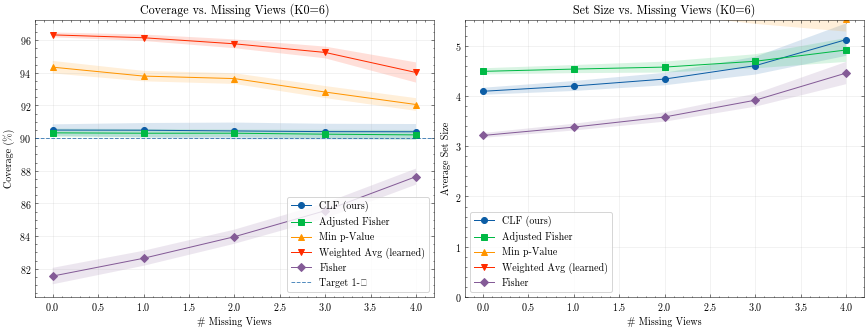

In [1]:
# Jupyter-friendly: CIFAR-10 Multi-View CP with Missing-View Sweep (CLF vs baselines)
# - Per-subset recalibration to keep CLF coverage valid
# - View-drop augmentation for robustness to missing views
# - Saves CSVs + a two-panel figure (Coverage / Set Size) using scienceplots
# ---------------------------------------------------------------

from __future__ import annotations
import warnings, itertools, os
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


import scienceplots  # noqa: F401
plt.style.use(['science', 'no-latex'])

# -----------------------------
# Config dataclass
# -----------------------------
@dataclass
class CIFARConfig:
    alpha: float = 0.1
    K0: int = 6                      # choose 4 or 6
    num_classes: int = 10
    num_simulations: int = 1         # increase for variance bars
    # training
    epochs_per_view: int = 40        # raise if you have GPU time
    lr: float = 1e-3
    batch_size: int = 512
    max_iter_lr: int = 1000
    train_seed_base: int = 42
    # data split fractions
    train_frac: float = 0.5
    cal_frac_of_temp: float = 0.3
    fuse_train_frac_of_rest: float = 0.7
    # fusion training robustness (augmentation)
    viewdrop_min_missing: int = 0
    viewdrop_max_missing: int = 3    # <= K0-1
    viewdrop_prob: float = 0.7
    # evaluation sweep
    eval_min_missing: int = 0        # set 1 to skip the no-missing case
    max_missing_to_eval: int = None  # None -> up to K0-1
    patterns_per_m: int = 6          # random subsets per missing count m
    # IO
    out_dir: str = "results_missing_views"

# -----------------------------
# Device & Data (Loaded once)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=_transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=_transform)

X_train_full = train_dataset.data.astype(np.float32) / 255.0
Y_train_full = np.array(train_dataset.targets)
X_test_full  = test_dataset.data.astype(np.float32) / 255.0
Y_test_full  = np.array(test_dataset.targets)

# -----------------------------
# Multi-view (patch) utilities
# -----------------------------
def split_image_into_k_patches(image: torch.Tensor, k: int) -> List[torch.Tensor]:
    C, H, W = image.shape
    if k == 4:
        patches = []
        for i in range(2):
            for j in range(2):
                patch = image[:, i*16:(i+1)*16, j*16:(j+1)*16]
                patches.append(patch)
        return patches
    else:
        base_width = W // k
        remainder = W % k
        patches, start = [], 0
        for idx in range(k):
            width = base_width + (1 if idx < remainder else 0)
            patch = image[:, :, start:start+width]
            patches.append(patch)
            start += width
        return patches

class PatchesDataset(torch.utils.data.Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, k: int, view: int):
        self.images = images
        self.labels = labels
        self.k = k
        self.view = view
    def __len__(self) -> int:
        return len(self.labels)
    def __getitem__(self, idx: int):
        img = self.images[idx].transpose((2, 0, 1))
        img = torch.tensor(img, dtype=torch.float32)
        patch = split_image_into_k_patches(img, self.k)[self.view]
        return patch, int(self.labels[idx])

# -----------------------------
# Simple CNN per view
# -----------------------------
class PredictorCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = None
        self.fc2 = None
        self.num_classes = num_classes
    def forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x
    def forward(self, x):
        x = self.forward_features(x)
        if self.fc1 is None:
            b, c, h, w = x.shape
            self.fc1 = nn.Linear(c*h*w, 128).to(x.device)
            self.fc2 = nn.Linear(128, self.num_classes).to(x.device)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def train_model(model: nn.Module, train_loader, num_epochs=100, lr=1e-3):
    crit = nn.CrossEntropyLoss()
    opt  = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for ep in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = torch.tensor(yb, dtype=torch.long, device=device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
        if (ep + 1) % 20 == 0 or ep == num_epochs - 1:
            print(f"  epoch {ep+1}/{num_epochs}")
    return model

# -----------------------------
# Conformal utilities
# -----------------------------
@torch.no_grad()
def compute_nonconformity_scores(model: nn.Module, loader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    scores, labels = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        probs = F.softmax(model(xb), dim=1)
        idx = torch.arange(probs.size(0), device=probs.device)
        true_p = probs[idx, torch.tensor(yb, dtype=torch.long, device=probs.device)]
        s = (1 - true_p).detach().cpu().numpy()
        scores.extend(s)
        labels.extend(yb.numpy())
    return np.asarray(scores, float), np.asarray(labels, int)

def classwise_scores(scores: np.ndarray, labels: np.ndarray, L: int) -> Dict[int, np.ndarray]:
    out = {c: [] for c in range(L)}
    for s, y in zip(scores, labels):
        out[int(y)].append(float(s))
    return {c: np.asarray(v, float) for c, v in out.items()}

@torch.no_grad()
def per_view_pvalues_and_probs(
    model: nn.Module, class_scores: Dict[int, np.ndarray], loader, L: int
) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    probs_all = []
    for xb, _ in loader:
        xb = xb.to(device)
        probs = F.softmax(model(xb), dim=1).detach().cpu().numpy()
        probs_all.append(probs)
    probs_all = np.vstack(probs_all)  # (n, L)
    n = probs_all.shape[0]
    pvals = np.zeros((n, L))
    for y in range(L):
        cal = class_scores.get(y, np.array([]))
        if cal.size == 0:
            pvals[:, y] = 1.0
        else:
            s_test = 1 - probs_all[:, y]
            counts = np.sum(cal[:, None] >= s_test[None, :], axis=0)
            pvals[:, y] = (1 + counts) / (len(cal) + 1)
    return pvals, probs_all

@torch.no_grad()
def compute_probs(model: nn.Module, loader) -> np.ndarray:
    model.eval()
    probs_all = []
    for xb, _ in loader:
        xb = xb.to(device)
        probs = F.softmax(model(xb), dim=1).detach().cpu().numpy()
        probs_all.append(probs)
    return np.vstack(probs_all)

# -----------------------------
# Fusion utilities & baselines
# -----------------------------
def build_fusion_features_with_masks(pvals_list: List[np.ndarray], probs_list: List[np.ndarray], masks: np.ndarray) -> np.ndarray:
    """Stack per-view [pvals, probs, mask] blocks. masks shape: (n, K) with 1 for present, 0 for missing."""
    blocks = []
    K = len(pvals_list)
    for k in range(K):
        n, L = pvals_list[k].shape
        mk = masks[:, [k]]  # (n,1)
        mask_block = np.repeat(mk, repeats=2*L, axis=1)
        blk = np.hstack([pvals_list[k], probs_list[k]])
        blk = blk * mask_block
        blk = np.hstack([blk, mk])  # add 1 indicator per view
        blocks.append(blk)
    return np.hstack(blocks)

def min_p_value_fusion(P_all_subset: np.ndarray) -> np.ndarray:
    Kp = P_all_subset.shape[0]
    return Kp * np.min(P_all_subset, axis=0)

def fisher_fusion(P_all_subset: np.ndarray) -> np.ndarray:
    eps = 1e-12
    p = np.clip(P_all_subset, eps, 1.0)
    T = -2 * np.sum(np.log(p), axis=0)
    df = 2 * P_all_subset.shape[0]
    return 1 - chi2.cdf(T, df=df)

def adjusted_fisher_params(P_train_subset: np.ndarray, y_train: np.ndarray, L: int):
    Kp, ntr, _ = P_train_subset.shape
    eps = 1e-12
    params = {}
    for y in range(L):
        idx = np.where(y_train == y)[0]
        if idx.size < 5:
            params[y] = ("fallback", None, None)
            continue
        P_cls = np.clip(P_train_subset[:, idx, y], eps, 1.0)
        W = -2 * np.log(P_cls)
        Wc = W - W.mean(axis=1, keepdims=True)
        Sigma = (Wc @ Wc.T) / max(W.shape[1] - 1, 1)
        var_T = np.sum(Sigma)
        if not np.isfinite(var_T) or var_T <= 0:
            var_T = 4 * Kp
        f_y = (8.0 * Kp * Kp) / var_T
        c_y = var_T / (4 * Kp)
        params[y] = ("ok", f_y, c_y)
    return params

def adjusted_fisher_fusion_subset(P_train_subset: np.ndarray, y_train: np.ndarray, P_test_subset: np.ndarray, L: int) -> np.ndarray:
    eps = 1e-12
    nte = P_test_subset.shape[1]
    out = np.zeros((nte, L))
    params = adjusted_fisher_params(P_train_subset, y_train, L)
    for y in range(L):
        status, f_y, c_y = params[y]
        if status != "ok":
            out[:, y] = fisher_fusion(P_test_subset)[:, y]
            continue
        P_t = np.clip(P_test_subset[:, :, y], eps, 1.0)
        T_t = -2 * np.sum(np.log(P_t), axis=0)
        out[:, y] = 1 - chi2.cdf(T_t / c_y, df=f_y)
    return out

def weighted_average_fusion_subset(P_all_subset: np.ndarray, y_train: np.ndarray):
    """Returns (apply_fn, weights). apply_fn(P_subset)->(n,L)"""
    Kp, ntr, L = P_all_subset.shape
    pv_tr_concat = np.concatenate([P_all_subset[k] for k in range(Kp)], axis=1)  # (ntr, K'*L)
    lr = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500, random_state=0)
    lr.fit(pv_tr_concat, y_train)
    B = lr.coef_  # (L, K'*L)
    imps = []
    for k in range(Kp):
        block = B[:, k*L:(k+1)*L]
        imps.append(np.linalg.norm(block, ord="fro"))
    w = np.array(imps, float)
    w = np.maximum(w, 1e-12)
    w = w / w.sum()
    def apply_weights(P_subset):
        return np.tensordot(w, P_subset, axes=(0,0))  # (n,L)
    return apply_weights, w

def fused_class_cal_scores(y_cal: np.ndarray, fused_probs_cal: np.ndarray, L: int) -> Dict[int, np.ndarray]:
    s = 1 - fused_probs_cal[np.arange(len(y_cal)), y_cal]
    out = {c: [] for c in range(L)}
    for sc, yy in zip(s, y_cal):
        out[int(yy)].append(float(sc))
    return {c: np.asarray(v, float) for c, v in out.items()}

def fused_p_values_from_cal(fused_probs: np.ndarray, cal_class_scores: Dict[int, np.ndarray]) -> np.ndarray:
    n, L = fused_probs.shape
    out = np.zeros((n, L))
    for y in range(L):
        cal = cal_class_scores.get(y, np.array([]))
        if cal.size == 0:
            out[:, y] = 1.0
        else:
            s_test = 1 - fused_probs[:, y]
            counts = np.sum(cal[:, None] >= s_test[None, :], axis=0)
            out[:, y] = (1 + counts) / (len(cal) + 1)
    return out

def evaluate_sets(P: np.ndarray, y_true: np.ndarray, alpha: float) -> Tuple[float, float]:
    C = (P > alpha)
    cov = float(np.mean(C[np.arange(len(y_true)), y_true]))
    size = float(np.mean(C.sum(axis=1)))
    return cov, size

# -----------------------------
# View-drop augmentation helpers
# -----------------------------
def random_missing_mask(n: int, K: int, min_missing: int, max_missing: int, prob_apply: float, rng: np.random.RandomState):
    mask = np.ones((n, K), dtype=np.float32)
    for i in range(n):
        if rng.rand() < prob_apply:
            m = rng.randint(min_missing, max_missing+1)
            miss = rng.choice(K, size=m, replace=False)
            mask[i, miss] = 0.0
    return mask

def apply_mask_to_perview_arrays(arr_list: List[np.ndarray], mask: np.ndarray) -> List[np.ndarray]:
    K = len(arr_list)
    out = []
    for k in range(K):
        arr = arr_list[k].copy()
        arr[mask[:,k] == 0] = 0.0
        out.append(arr)
    return out

# -----------------------------
# Main experiment with missing-view sweep
# -----------------------------
def run_missing_view_sweep(cfg: CIFARConfig):
    os.makedirs(cfg.out_dir, exist_ok=True)
    all_rows = []
    for sim in range(cfg.num_simulations):
        print(f"\n=== Simulation {sim+1}/{cfg.num_simulations} ===")
        seed = cfg.train_seed_base + sim
        rng  = np.random.RandomState(seed)

        # Splits
        X_trP, X_tmp, y_trP, y_tmp = train_test_split(
            X_train_full, Y_train_full,
            test_size=1 - cfg.train_frac, stratify=Y_train_full, random_state=seed
        )
        X_cal, X_rest, y_cal, y_rest = train_test_split(
            X_tmp, y_tmp,
            test_size=1 - cfg.cal_frac_of_temp, stratify=y_tmp, random_state=seed
        )
        X_fuse_tr, X_fuse_cal, y_fuse_tr, y_fuse_cal = train_test_split(
            X_rest, y_rest,
            test_size=1 - cfg.fuse_train_frac_of_rest, stratify=y_rest, random_state=seed
        )
        X_te, y_te = X_test_full, Y_test_full

        K0 = cfg.K0
        num_views = 4 if K0 == 4 else K0

        # Build loaders per view
        loaders = {}
        for v in range(num_views):
            loaders[v] = dict(
                train=torch.utils.data.DataLoader(PatchesDataset(X_trP,      y_trP,      K0, v), batch_size=cfg.batch_size, shuffle=True),
                cal  =torch.utils.data.DataLoader(PatchesDataset(X_cal,      y_cal,      K0, v), batch_size=cfg.batch_size, shuffle=False),
                ftr  =torch.utils.data.DataLoader(PatchesDataset(X_fuse_tr,  y_fuse_tr,  K0, v), batch_size=cfg.batch_size, shuffle=False),
                fcal =torch.utils.data.DataLoader(PatchesDataset(X_fuse_cal, y_fuse_cal, K0, v), batch_size=cfg.batch_size, shuffle=False),
                te   =torch.utils.data.DataLoader(PatchesDataset(X_te,       y_te,       K0, v), batch_size=cfg.batch_size, shuffle=False),
            )

        # Train per-view models
        models, cal_classwise = [], []
        for v in range(num_views):
            print(f"  [View {v+1}/{num_views}] training...")
            m = PredictorCNN(num_classes=cfg.num_classes)
            m = train_model(m, loaders[v]["train"], num_epochs=cfg.epochs_per_view, lr=cfg.lr)
            models.append(m)
            sc, lab = compute_nonconformity_scores(m, loaders[v]["cal"])
            cal_classwise.append(classwise_scores(sc, lab, cfg.num_classes))

        # Per-view p/probs for fusion train/cal/test (full K0)
        pv_tr, pr_tr = [], []
        pv_cal, pr_cal = [], []
        pv_te,  pr_te  = [], []
        for v in range(num_views):
            p, pr = per_view_pvalues_and_probs(models[v], cal_classwise[v], loaders[v]["ftr"], cfg.num_classes)
            pv_tr.append(p); pr_tr.append(pr)
            p, pr = per_view_pvalues_and_probs(models[v], cal_classwise[v], loaders[v]["fcal"], cfg.num_classes)
            pv_cal.append(p); pr_cal.append(pr)
            p, pr = per_view_pvalues_and_probs(models[v], cal_classwise[v], loaders[v]["te"],  cfg.num_classes)
            pv_te.append(p);  pr_te.append(pr)

        n_ftr = pv_tr[0].shape[0]
        n_fcal = pv_cal[0].shape[0]
        n_te = pv_te[0].shape[0]
        L = cfg.num_classes

        # === Train CLF (LogisticRegression) with view-drop augmentation ===
        mask_train = random_missing_mask(
            n=n_ftr, K=K0,
            min_missing=cfg.viewdrop_min_missing,
            max_missing=min(cfg.viewdrop_max_missing, K0-1),
            prob_apply=cfg.viewdrop_prob, rng=rng
        )
        X_ftr = build_fusion_features_with_masks(
            apply_mask_to_perview_arrays(pv_tr, mask_train),
            apply_mask_to_perview_arrays(pr_tr, mask_train),
            mask_train
        )
        fusion_lr = LogisticRegression(max_iter=cfg.max_iter_lr, multi_class="multinomial",
                                       solver="lbfgs", random_state=seed)
        fusion_lr.fit(X_ftr, y_fuse_tr)

        # Precompute full training P for baselines
        P_train_full = np.stack(pv_tr, axis=0)   # (K0, ntr, L)
        P_test_full  = np.stack(pv_te,  axis=0)  # (K0, nte, L)

        # ---- helper: evaluate a subset with PER-SUBSET RECALIBRATION ----
        def eval_on_subset(keep_views: List[int], tag_missing: int):
            """
            Recalibrate the fused model on the same subset/mask to keep exchangeability.
            Baselines already recomputed on subset.
            """
            Kp = len(keep_views)

            # (1) Build masked CALIB features for THIS subset
            mask_cal_sub = np.zeros((n_fcal, K0), dtype=np.float32)
            mask_cal_sub[:, keep_views] = 1.0
            X_fcal_sub = build_fusion_features_with_masks(
                [pv_cal[k] for k in range(K0)],
                [pr_cal[k] for k in range(K0)],
                mask_cal_sub
            )
            fused_probs_cal_sub = fusion_lr.predict_proba(X_fcal_sub)
            fused_cal_scores_sub = fused_class_cal_scores(y_fuse_cal, fused_probs_cal_sub, L)

            # (2) Build masked TEST features for THIS subset
            mask_te = np.zeros((n_te, K0), dtype=np.float32)
            mask_te[:, keep_views] = 1.0
            X_ftest = build_fusion_features_with_masks(
                [pv_te[k] for k in range(K0)],
                [pr_te[k] for k in range(K0)],
                mask_te
            )
            fused_probs_test = fusion_lr.predict_proba(X_ftest)
            P_cf = fused_p_values_from_cal(fused_probs_test, fused_cal_scores_sub)

            # (3) Baselines on subset
            P_train_sub = P_train_full[keep_views, :, :]  # (Kp, ntr, L)
            P_test_sub  = P_test_full[keep_views,  :, :]
            P_min  = min_p_value_fusion(P_test_sub)
            P_fi   = fisher_fusion(P_test_sub)
            P_adjF = adjusted_fisher_fusion_subset(P_train_sub, y_fuse_tr, P_test_sub, L)
            apply_wavg, w_learned = weighted_average_fusion_subset(P_train_sub, y_fuse_tr)
            P_wavg = apply_wavg(P_test_sub)

            # (4) Metrics
            cov_cf, set_cf = evaluate_sets(P_cf, y_te, cfg.alpha)
            cov_min, set_min = evaluate_sets(P_min, y_te, cfg.alpha)
            cov_fi,  set_fi  = evaluate_sets(P_fi,  y_te, cfg.alpha)
            cov_afi, set_afi = evaluate_sets(P_adjF,y_te, cfg.alpha)
            cov_wl,  set_wl  = evaluate_sets(P_wavg,y_te, cfg.alpha)

            row = dict(
                Sim=sim, K0=K0, Kept=Kp, Missing=tag_missing, KeepViews=str(keep_views),
                CLF_Cov=100*cov_cf, CLF_Set=set_cf,
                MinPV_Cov=100*cov_min, MinPV_Set=set_min,
                Fisher_Cov=100*cov_fi, Fisher_Set=set_fi,
                AdjF_Cov=100*cov_afi, AdjF_Set=set_afi,
                WAvgL_Cov=100*cov_wl, WAvgL_Set=set_wl
            )
            return row

        # Sweep missing views
        start_m = cfg.eval_min_missing
        max_m = cfg.max_missing_to_eval if cfg.max_missing_to_eval is not None else (K0-1)
        max_m = min(max_m, K0-1)
        rng2 = np.random.RandomState(seed+12345)
        for m in range(start_m, max_m+1):
            Kp = K0 - m
            all_subsets = list(itertools.combinations(range(K0), Kp))
            if len(all_subsets) > cfg.patterns_per_m:
                keep_sets = rng2.choice(len(all_subsets), size=cfg.patterns_per_m, replace=False)
                subsets = [list(all_subsets[i]) for i in keep_sets]
            else:
                subsets = [list(s) for s in all_subsets]
            print(f"  -> Missing {m} (keep {Kp}) patterns: {len(subsets)}")
            for keep in subsets:
                row = eval_on_subset(keep, m)
                all_rows.append(row)

        # ref accuracy (full K0)
        avg_probs = np.mean(np.stack(pr_te, axis=0), axis=0)
        acc_ref = accuracy_score(y_te, np.argmax(avg_probs, axis=1)) * 100.0
        print(f"Reference (avg probs) accuracy: {acc_ref:.2f}%")

        # cleanup
        for m in models:
            m.to("cpu")
        del models

    df = pd.DataFrame(all_rows).sort_values(["Sim", "Missing", "Kept"])
    os.makedirs(cfg.out_dir, exist_ok=True)
    out_csv = os.path.join(cfg.out_dir, f"missing_view_sweep_K{cfg.K0}_revised.csv")
    df.to_csv(out_csv, index=False)

    # quick summaries
    summary = df.groupby(["Missing"]).agg({
        "CLF_Cov":"mean","CLF_Set":"mean",
        "MinPV_Cov":"mean","MinPV_Set":"mean",
        "Fisher_Cov":"mean","Fisher_Set":"mean",
        "AdjF_Cov":"mean","AdjF_Set":"mean",
        "WAvgL_Cov":"mean","WAvgL_Set":"mean",
    }).reset_index()
    sum_csv = os.path.join(cfg.out_dir, f"missing_view_summary_K{cfg.K0}_revised.csv")
    summary.to_csv(sum_csv, index=False)

    print("\nSaved:")
    print(f" - {out_csv}")
    print(f" - {sum_csv}")
    print("\nSummary (means across patterns per #missing):")
    print(summary.to_string(index=False))

    # ---- Plot + display inline ----
    plot_missing_view_summary(k0=cfg.K0, csv_dir=cfg.out_dir)
    plt.show()

def plot_missing_view_summary(k0=6, csv_dir="results_missing_views", out_prefix=None):
    csv_path = os.path.join(csv_dir, f"missing_view_sweep_K{k0}_revised.csv")
    df = pd.read_csv(csv_path)

    # metrics to plot
    cov_cols = ["CLF_Cov","MinPV_Cov","Fisher_Cov","AdjF_Cov","WAvgL_Cov"]
    set_cols = ["CLF_Set","MinPV_Set","Fisher_Set","AdjF_Set","WAvgL_Set"]

    # group by Missing
    g = df.groupby("Missing")
    mean_cov = g[cov_cols].mean()
    std_cov  = g[cov_cols].std().fillna(0.0)
    mean_set = g[set_cols].mean()
    std_set  = g[set_cols].std().fillna(0.0)

    xs = mean_cov.index.values

    # pretty labels
    label_map = {
        "CLF": "CLF (ours)",
        "MinPV": "Min p-Value",
        "Fisher": "Fisher",
        "AdjF": "Adjusted Fisher",
        "WAvgL": "Weighted Avg (learned)"
    }

    # order for legend/lines
    order_cov = ["CLF_Cov","AdjF_Cov","MinPV_Cov","WAvgL_Cov","Fisher_Cov"]
    order_set = ["CLF_Set","AdjF_Set","MinPV_Set","WAvgL_Set","Fisher_Set"]

    styles = {
        "CLF":   dict(marker="o"),
        "AdjF":  dict(marker="s"),
        "MinPV": dict(marker="^"),
        "WAvgL": dict(marker="v"),
        "Fisher":dict(marker="D"),
    }

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), constrained_layout=True)

    # --- Coverage subplot ---
    ax = axes[0]
    for key in order_cov:
        base = key.replace("_Cov","")
        lbl = label_map[base]
        style = styles.get(base, {})
        ax.plot(xs, mean_cov[key].values, label=lbl, **style)
        ax.fill_between(xs,
                        (mean_cov[key] - std_cov[key]).values,
                        (mean_cov[key] + std_cov[key]).values,
                        alpha=0.15)
    ax.axhline(90.0, linestyle="--", linewidth=1, label="Target 1-α", alpha=0.7)
    ax.set_xlabel("# Missing Views")
    ax.set_ylabel("Coverage (%)")
    ax.set_title(f"Coverage vs. Missing Views (K0={k0})")
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=True)

    # --- Set size subplot ---
    ax = axes[1]
    for key in order_set:
        base = key.replace("_Set","")
        lbl = label_map[base]
        style = styles.get(base, {})
        ax.plot(xs, mean_set[key].values, label=lbl, **style)
        ax.fill_between(xs,
                        (mean_set[key] - std_set[key]).values,
                        (mean_set[key] + std_set[key]).values,
                        alpha=0.15)
        ax.set_ylim(bottom=0)
    ax.set_xlabel("# Missing Views")
    ax.set_ylabel("Average Set Size")
    ax.set_title(f"Set Size vs. Missing Views (K0={k0})")
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=True)

    if out_prefix is None:
        out_prefix = os.path.join(csv_dir, f"fig_missing_view_sweep_K{k0}_revised")
    png_path = out_prefix + ".png"
    pdf_path = out_prefix + ".pdf"
    plt.savefig(png_path, dpi=220)
    plt.savefig(pdf_path)
    print(f"Saved figure: {png_path}")
    print(f"Saved figure: {pdf_path}")

# ===========================
# Configure & Run (Notebook)
# ===========================
# You can edit these, then re-run the cell:
K_LIST = [6]            # set to [4], [6], or [4,6] to run both sequentially
EPOCHS = 40             # lower for quick dry run (e.g., 10); higher for better accuracy
SIMS   = 10              # increase for error bars
EVAL_MIN_MISSING = 0    # start sweep at 1 missing view; set 0 to include the no-missing point
EVAL_MAX_MISSING = 4    # end sweep at 3 missing views; set to None for up to K0-1
PATTERNS_PER_M  = 6     # random subsets per missing-count

for K0 in K_LIST:
    cfg = CIFARConfig(
        K0=K0,
        epochs_per_view=EPOCHS,
        num_simulations=SIMS,
        eval_min_missing=EVAL_MIN_MISSING,
        max_missing_to_eval=EVAL_MAX_MISSING,
        patterns_per_m=PATTERNS_PER_M,
        viewdrop_min_missing=0,
        viewdrop_max_missing=min(5, K0-1),
        viewdrop_prob=0.7,
        out_dir="results_missing_views"
    )
    print("\nConfig:")
    print(cfg)
    run_missing_view_sweep(cfg)


Saved: results_missing_views/fig_missing_view_sweep_K6_colors_markers.png
Saved: results_missing_views/fig_missing_view_sweep_K6_colors_markers.pdf
Saved: results_missing_views/fig_missing_view_sweep_K6_colors_markers.svg


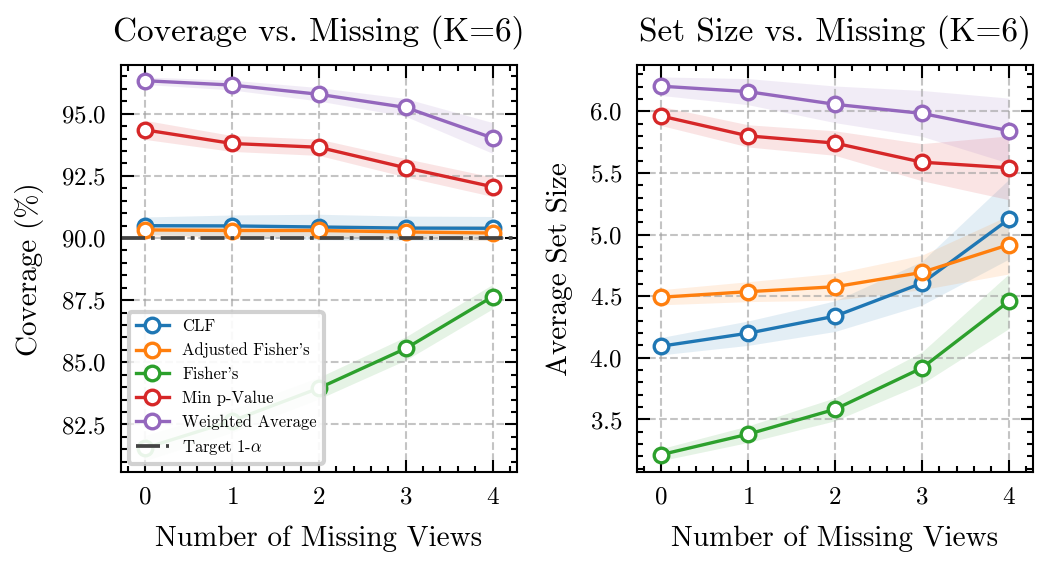

In [2]:
# --- Paper-ready plot: unified grid (matches α-sweep), color order, WITH circle markers, single legend on left ---

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ── Style & typography (editable text in vector exports)
plt.style.use(['science', 'no-latex'])

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42
mpl.rcParams.update({
    # keep text editable in vector exports
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    # print-appropriate sizes
    "font.size": 7,
    "axes.titlesize": 8,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 4,
    # lines
    "lines.linewidth": 0.8,
    "axes.linewidth": 0.5,
})

# ── Unified grid style (explicit so it matches your other figure)
GRID_KW = {
    "axes.grid": True,
    "grid.color": "#9e9e9e",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.alpha": 0.6,
}
mpl.rcParams.update(GRID_KW)


def plot_missing_view_summary_colors_markers(
    k0=6,
    csv_dir="results_missing_views",
    out_prefix=None,
    pad=0.28,           # slight x padding so points aren't on the frame
    figsize=(3.54, 2),     # change to (3.54, 2) if you want the small paper size
    dpi=300
):
    # load results
    csv_path = os.path.join(csv_dir, f"missing_view_sweep_K{k0}_revised.csv")
    df = pd.read_csv(csv_path)

    cov_cols = ["CLF_Cov","AdjF_Cov","Fisher_Cov","MinPV_Cov","WAvgL_Cov"]
    set_cols = ["CLF_Set","AdjF_Set","Fisher_Set","MinPV_Set","WAvgL_Set"]
    for col in cov_cols + set_cols + ["Missing"]:
        if col not in df.columns:
            raise ValueError(f"CSV missing expected column: {col}")

    # group means/stds by # missing
    g = df.groupby("Missing")
    xs = g.size().index.values
    mean_cov = g[cov_cols].mean()
    std_cov  = g[cov_cols].std().fillna(0.0)
    mean_set = g[set_cols].mean()
    std_set  = g[set_cols].std().fillna(0.0)

    # legend order (keep exactly)
    order_cov = [
        ("CLF_Cov",   "CLF"),
        ("AdjF_Cov",  "Adjusted Fisher's"),
        ("Fisher_Cov","Fisher's"),
        ("MinPV_Cov", "Min p-Value"),
        ("WAvgL_Cov", "Weighted Average"),
    ]
    order_set = [
        ("CLF_Set",   "CLF"),
        ("AdjF_Set",  "Adjusted Fisher's"),
        ("Fisher_Set","Fisher's"),
        ("MinPV_Set", "Min p-Value"),
        ("WAvgL_Set", "Weighted Average"),
    ]

    # requested color order across the legend: blue, orange, green, red, purple
    palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
    color_map = {
        "CLF":               palette[0],  # blue
        "Adjusted Fisher's": palette[1],  # orange
        "Fisher's":          palette[2],  # green
        "Min p-Value":       palette[3],  # red
        "Weighted Average":  palette[4],  # purple
        "Target 1-alpha":    "#444444",
    }

    # marker styling (open circles)
    mk = dict(marker='o', markersize=3.5, markerfacecolor='white', markeredgewidth=0.8)

    fig, (axL, axR) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)

    # ----- Coverage (left) -----
    handles = []
    for (key, label) in order_cov:
        y  = mean_cov[key].values
        lo = (mean_cov[key] - std_cov[key]).values
        hi = (mean_cov[key] + std_cov[key]).values
        ln, = axL.plot(xs, y, color=color_map[label], label=label, **mk)
        handles.append(ln)
        if np.any(std_cov[key].values > 0):
            axL.fill_between(xs, lo, hi, color=color_map[label], alpha=0.12, linewidth=0)

    # target 1-alpha line
    target = axL.axhline(90.0, linestyle="-.", linewidth=0.9, color=color_map["Target 1-alpha"])

    # your titles/labels kept as-is
    axL.set_xlabel("Number of Missing Views")
    axL.set_ylabel("Coverage (%)")
    axL.set_title(f"Coverage vs. Missing (K={k0})")
    axL.xaxis.set_major_locator(MaxNLocator(integer=True))
    axL.set_xlim(xs.min() - pad, xs.max() + pad)
    axL.margins(y=0.03)

    # single legend on left (exact order + target)
    legend_labels  = [lbl for _, lbl in order_cov] + [r"Target 1-$\alpha$"]
    legend_handles = handles + [target]
    axL.legend(legend_handles, legend_labels, frameon=True, ncol=1, loc="lower left", framealpha=0.9)

    # ----- Set size (right) -----
    for (key, label) in order_set:
        y  = mean_set[key].values
        lo = (mean_set[key] - std_set[key]).values
        hi = (mean_set[key] + std_set[key]).values
        axR.plot(xs, y, color=color_map[label], **mk)
        if np.any(std_set[key].values > 0):
            axR.fill_between(xs, lo, hi, color=color_map[label], alpha=0.12, linewidth=0)

    axR.set_xlabel("Number of Missing Views")
    axR.set_ylabel("Average Set Size")
    axR.set_title(f"Set Size vs. Missing (K={k0})")
    axR.xaxis.set_major_locator(MaxNLocator(integer=True))
    axR.set_xlim(xs.min() - pad, xs.max() + pad)
    axR.margins(y=0.03)

    # ── Make grids match exactly & disable minor grids on both subplots
    for ax in (axL, axR):
        ax.grid(True, which="major", axis="both")
        ax.grid(False, which="minor")

    # layout & save
    if out_prefix is None:
        out_prefix = os.path.join(csv_dir, f"fig_missing_view_sweep_K{k0}_colors_markers")
    png_path = out_prefix + ".png"
    pdf_path = out_prefix + ".pdf"
    svg_path = out_prefix + ".svg"

    plt.tight_layout(w_pad=1.0)
    plt.savefig(png_path, dpi=dpi)
    plt.savefig(pdf_path)
    plt.savefig(svg_path)
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")
    print(f"Saved: {svg_path}")
    plt.show()


# run (set k0=4 if your CSV is for K0=4)
plot_missing_view_summary_colors_markers(k0=6, csv_dir="results_missing_views", pad=0.28)
